## 使用 Regularization 解决过度拟合的问题

下面是工厂测试是根据产品参数判断产品是否通过的例子。

### Visualizing data

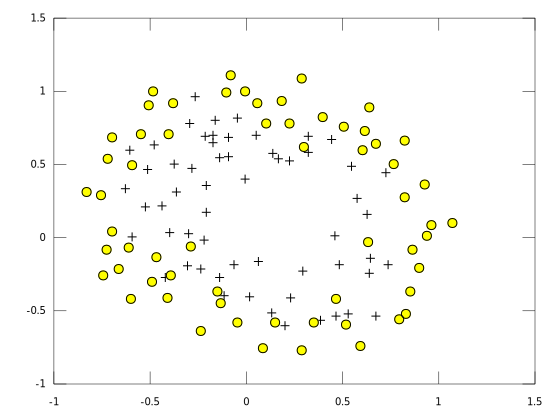

In [33]:
clc;
clear;
close all;

data = load('ex2data2.txt');
x = data(:, 1:2);
y = data(:, 3);
pos = find(y == 1);
neg = find(y == 0);
hold on;
plot(x(pos, 1), x(pos, 2), 'k+', 'markersize', 3);
plot(x(neg, 1), x(neg, 2), 'ko', 'markersize', 3, 'markerFaceColor', 'y');
hold off;

### Without Feature Mapping and Regularization

#### Sigmoid Function

In [34]:
% Compute Sigmoid Function
function g = sigmoid(x)
    g = 1 ./ (1 + exp(-x));
end

In [35]:
% Compute Cost Function and Grad
function [J, grad] = computeCost(theta, X, y)
    m = length(y);
    h = sigmoid(X * theta);
    
    J = -(1 / m) * sum(y .* log(h) + (1 - y) .* log(1 - h));
    grad = (1 / m) * X' * (h - y);
end

In [36]:
m = size(x, 1);
X = [ones(m, 1), x];
n = size(X, 2);
theta = zeros(n, 1);
[J, grad] = computeCost(theta, X, y)

J =  0.69315
grad =

   8.4746e-03
   1.8788e-02
   7.7771e-05



### Compute theta using fminunc

In [44]:
options = optimset('GradObj', 'on', 'MaxIter', 400);
initial_theta = zeros(n, 1);
[theta, cost] = fminunc(@(t)(computeCost(t, X, y)), initial_theta, options)

theta =

  -0.014185
  -0.303528
  -0.018218

cost =  0.69024


### Plotting Decision Boundary

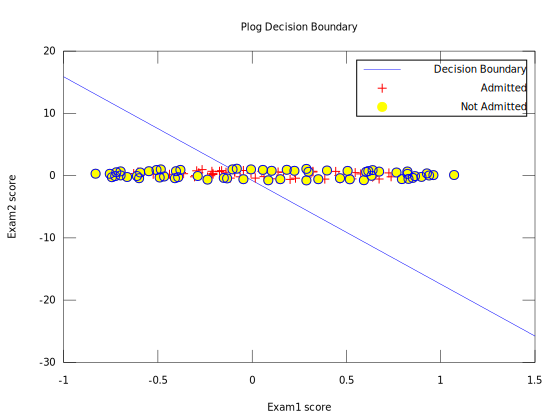

In [53]:
x1 = [-1:0.01:1.5];
x2 = - (theta(1) .+ theta(2) .* x1)./theta(3);
pos = find(y == 1);
net = find(y == 0);
hold on;
plot(x1, x2, '-')
plot(x(pos, 1), x(pos, 2), 'r+', 'markersize', 3)
plot(x(neg, 1), x(neg, 2), 'bo', 'markerSize', 3, 'MarkerFaceColor', 'y')
legend('Decision Boundary', 'Admitted', 'Not Admitted')
xlabel('Exam1 score')
ylabel('Exam2 score')
title('Plog Decision Boundary')
hold off;

上图所示，如果当只用两个特征时，你只能拟合出一条直线出来。所以我们要想好怎样利用这两个 feature, 我们可以把特征进行 map, 
生成更多的特征来进行拟合。

### Feature Mapping

将现有的特征映射到更多的维度。

In [56]:
% 根据二项式展开来映射更多的特征
function out = mapFeature(X1, X2, degree)
    m = size(X1, 1);
    out = ones(m, 1);
    
    for i = 1:degree
        for j = 0:i
            out(:, end + 1) = X1 .^ (i - j) .* X2 .^ (j);
        end
    end
end
    

In [80]:
a = [-3; 2];
b = [2; 3];
mapFeature(a, b, 6)
mapFeature(2, 3, 3)

ans =

 Columns 1 through 13:

     1    -3     2     9    -6     4   -27    18   -12     8    81   -54    36
     1     2     3     4     6     9     8    12    18    27    16    24    36

 Columns 14 through 26:

   -24    16  -243   162  -108    72   -48    32   729  -486   324  -216   144
    54    81    32    48    72   108   162   243    64    96   144   216   324

 Columns 27 and 28:

   -96    64
   486   729

ans =

    1    2    3    4    6    9    8   12   18   27



### Logistic Regression Without Regularization


首先将我们的维度，调用 `mapFeature` 进行 Feature Mapping. 求出拟合参数。

In [75]:
mX = mapFeature(x(:, 1), x(:,2), 6);
[m, n] = size(mX);
theta = zeros(n, 1);
options = optimset('GradObj', 'on', 'MaxIter', 400);
initial_theta = zeros(n, 1);
[theta, cost] = fminunc(@(t)(computeCost(t, mX, y)), initial_theta, options)

theta =

    1.79571
   -2.88733
    1.12066
   -1.54554
   -9.71673
   12.04460
    7.08675
   24.57407
   40.79083
    2.69598
   15.81996
   -2.50585
  -29.59604
   -5.02291
  -43.13834
   11.36623
   -4.28287
    0.73731
  -15.99184
  -34.02226
   26.42723
  -54.85742
  -28.71752
  -10.76192
   24.04492
  -52.71023
  -34.19925
   -6.83135

cost =  0.28371


### Plotting Decision Boundary


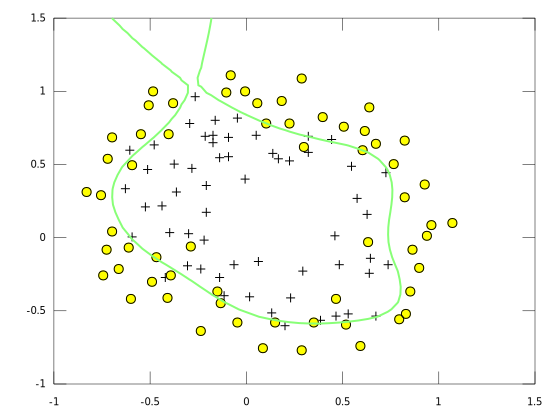

In [90]:
pos = find(y == 1);
neg = find(y == 0);
hold on;
plot(x(pos,1), x(pos, 2), 'k+', 'markersize', 3);
plot(x(neg,1), x(neg, 2), 'ko', 'markersize', 3, 'markerFaceColor', 'y');

u = linspace(-1, 1.5, 50);
v = linspace(-1, 1.5, 50);

z = zeros(length(u), length(v));
% Evaluate z = theta*x over the grid
for i = 1:length(u)
    for j = 1:length(v)
        z(i,j) = mapFeature(u(i), v(j), 6)*theta;
    end
end
z = z'; % important to transpose z before calling contour

% Plot z = 0
% Notice you need to specify the range [0, 0]
contour(u, v, z, [0, 0], 'LineWidth', 2)

hold off;

### Logistic Regression with Regularization

In [151]:
% Compute cost function
function [J, grad] = computeCostReg(theta, X, y, lambda)
    [m, n] = size(X);
    h = sigmoid(X * theta);
    J = -(1 / m) * sum(y .* log(h) + (1 - y) .* log(1 - h)) + (lambda / (2 * m)) * sum(theta(2:end) .^ 2);
    grad = (1 / m) * X' * (h - y) + (lambda / m) .* theta;
    grad(1) = grad(1) - (lambda / m) * theta(1);
end

In [137]:
mX = mapFeature(x(:, 1), x(:,2), 6);
[m, n] = size(mX);
theta = zeros(n, 1);
options = optimset('GradObj', 'on', 'MaxIter', 400);
initial_theta = zeros(n, 1);
[theta, cost] = fminunc(@(t)(computeCostReg(t, mX, y, 1)), initial_theta, options)

theta =

   1.273005
   0.624876
   1.177376
  -2.020142
  -0.912616
  -1.429907
   0.125668
  -0.368551
  -0.360033
  -0.171068
  -1.460894
  -0.052499
  -0.618889
  -0.273745
  -1.192301
  -0.240993
  -0.207934
  -0.047224
  -0.278327
  -0.296602
  -0.453957
  -1.045511
   0.026463
  -0.294330
   0.014381
  -0.328703
  -0.143796
  -0.924883

cost =  0.52900


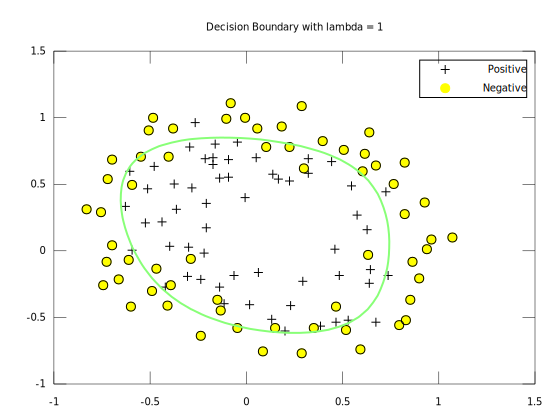

In [142]:
pos = find(y == 1);
neg = find(y == 0);
hold on;
plot(x(pos,1), x(pos, 2), 'k+', 'markersize', 3);
plot(x(neg,1), x(neg, 2), 'ko', 'markersize', 3, 'markerFaceColor', 'y');

u = linspace(-1, 1.5, 50);
v = linspace(-1, 1.5, 50);

z = zeros(length(u), length(v));
% Evaluate z = theta*x over the grid
for i = 1:length(u)
    for j = 1:length(v)
        z(i,j) = mapFeature(u(i), v(j), 6)*theta;
    end
end
z = z'; % important to transpose z before calling contour

% Plot z = 0
% Notice you need to specify the range [0, 0]
contour(u, v, z, [0, 0], 'LineWidth', 2)
legend('Positive', 'Negative')
title('Decision Boundary with lambda = 1')
hold off;

### Lambda = 0, overfitting

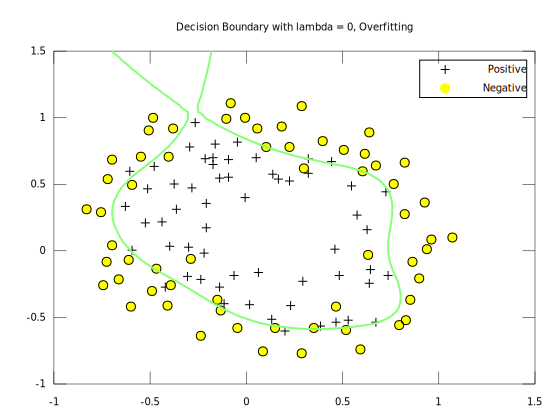

In [143]:
mX = mapFeature(x(:, 1), x(:,2), 6);
[m, n] = size(mX);
theta = zeros(n, 1);
options = optimset('GradObj', 'on', 'MaxIter', 400);
initial_theta = zeros(n, 1);
[theta, cost] = fminunc(@(t)(computeCostReg(t, mX, y, 0)), initial_theta, options);

pos = find(y == 1);
neg = find(y == 0);
hold on;
plot(x(pos,1), x(pos, 2), 'k+', 'markersize', 3);
plot(x(neg,1), x(neg, 2), 'ko', 'markersize', 3, 'markerFaceColor', 'y');

u = linspace(-1, 1.5, 50);
v = linspace(-1, 1.5, 50);

z = zeros(length(u), length(v));
% Evaluate z = theta*x over the grid
for i = 1:length(u)
    for j = 1:length(v)
        z(i,j) = mapFeature(u(i), v(j), 6)*theta;
    end
end
z = z'; % important to transpose z before calling contour

% Plot z = 0
% Notice you need to specify the range [0, 0]
contour(u, v, z, [0, 0], 'LineWidth', 2)
legend('Positive', 'Negative')
title('Decision Boundary with lambda = 0, Overfitting')
hold off;


### Lambda = 100, underfitting

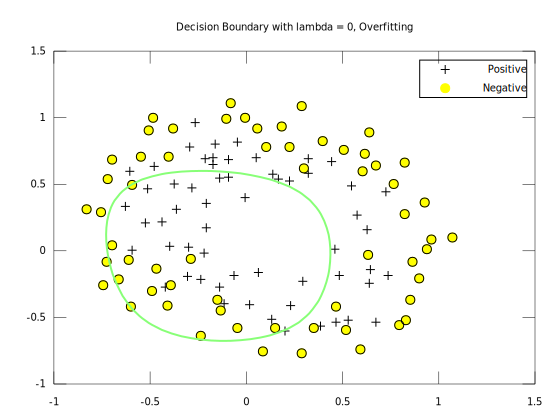

In [149]:
mX = mapFeature(x(:, 1), x(:,2), 6);
[m, n] = size(mX);
theta = zeros(n, 1);
options = optimset('GradObj', 'on', 'MaxIter', 400);
initial_theta = zeros(n, 1);
[theta, cost] = fminunc(@(t)(computeCostReg(t, mX, y, 100)), initial_theta, options);

pos = find(y == 1);
neg = find(y == 0);
hold on;
plot(x(pos,1), x(pos, 2), 'k+', 'markersize', 3);
plot(x(neg,1), x(neg, 2), 'ko', 'markersize', 3, 'markerFaceColor', 'y');

u = linspace(-1, 1.5, 50);
v = linspace(-1, 1.5, 50);

z = zeros(length(u), length(v));
% Evaluate z = theta*x over the grid
for i = 1:length(u)
    for j = 1:length(v)
        z(i,j) = mapFeature(u(i), v(j), 6)*theta;
    end
end
z = z'; % important to transpose z before calling contour

% Plot z = 0
% Notice you need to specify the range [0, 0]
contour(u, v, z, [0, 0], 'LineWidth', 2)
legend('Positive', 'Negative')
title('Decision Boundary with lambda = 0, Overfitting')
hold off;